In [3]:
# from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy
# from pywt import wavedec, dwt_max_level, Wavelet, threshold, waverec
import pywt
import skimage
import cv2

In [47]:
img = skimage.io.imread('dataset\cameraman.tif')
img_float = skimage.util.img_as_float32(img)
img.shape
# img_float = np.array(img).astype(np.float64)

(512, 512)

In [ ]:
# Add Noise Function
def addGaussianNoise(image, mean = 0, sigma = 15):        
    var = (sigma / 255) ** 2
    noisy_img = skimage.util.random_noise(image, mode='gaussian', mean = mean, var = var)
    return noisy_img

def add_salt_and_pepper_noise(image, amount = 0.05):      
    noisy_img = skimage.util.random_noise(image, mode='s&p', amount=amount)
    return noisy_img

# uniform NOISE

# Master Noise Function
def addNoise(image, mode = 'gaussian', mean = 0, sigma = 15, amount = 0.05):
    if image is not None:
        if mode == 'gaussian':
            return addGaussianNoise(image, mean, sigma)
        elif mode == 's&p':
            return add_salt_and_pepper_noise(image, amount)
    return image

In [ ]:
# Types of Thresholding
def hard_threshold(coeffs, threshold):
    return coeffs * (np.abs(coeffs) > threshold)

def soft_threshold(coeffs, threshold):
    return np.sign(coeffs) * np.maximum(np.abs(coeffs) - threshold, 0)

# Master Threshold Function
def applyThreshold(coeffs, mode = 'hard', threshold = 0):
    if coeffs is not None:
        if mode == 'hard':
            return hard_threshold(coeffs, threshold)
        elif mode == 'soft':
            return soft_threshold(coeffs, threshold)
    return coeffs

In [41]:
def get_visushrink_threshold(coeffs, N):          # N is the total no. of image pixels, see if it can be calculated from coeffs
    hh1 = coeffs[-1][2]
    median_hh1 = np.median(np.abs(hh1))
    sigma_est = median_hh1 / 0.6745

    # 2. Calculate the threshold
    # N is the total number of pixels in the image.
    threshold = sigma_est * np.sqrt(2 * np.log(N))
    return threshold

In [14]:
# Smoothing Function
def gaussianSmoothing(noisy_image, size = 5, sigma = 0):
    return cv2.GaussianBlur(noisy_image, (size, size), sigma)

def baseline_median_filter(noisy_image, size = 5):
    return cv2.medianBlur(noisy_image, size)

In [33]:
# For Gaussian:  sigma = Low: 15     Moderate:  25     High: 50
# For S&P:      amount = Low: 0.05   Moderate: 0.1     High: 0.2

noisy_img = addNoise(img_float, mode = 'gaussian', mean = 0, sigma = 15)

Text(0.5, 1.0, 'Noisy Image')

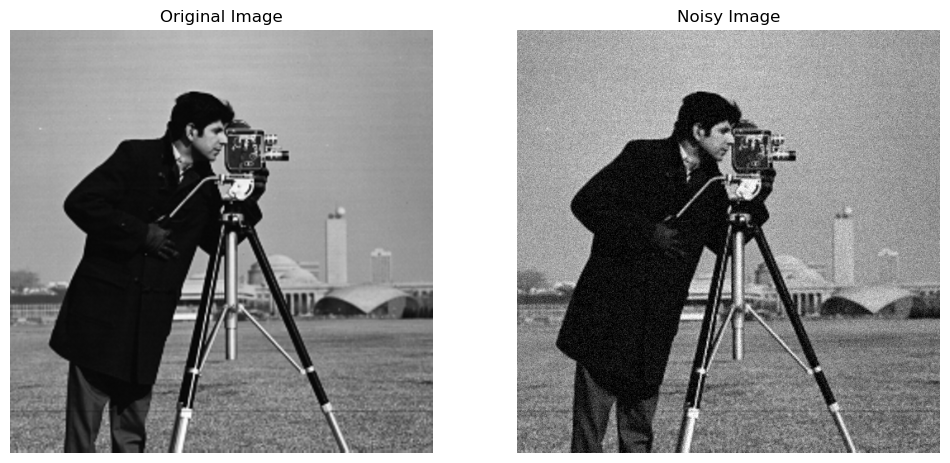

In [34]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(12,10))

axes[0].imshow(img, cmap='gray')
axes[0].axis('off')
axes[0].set_title("Original Image")

axes[1].imshow(noisy_img, cmap='gray')
axes[1].axis('off')
axes[1].set_title("Noisy Image")

In [72]:
coeff = pywt.wavedec2(noisy_img, wavelet='db4', level=3)
coeff

[array([[4.95780993, 4.93392223, 4.95428462, ..., 4.96293752, 4.7563905 ,
         4.68457654],
        [4.94730804, 4.92258438, 4.93857031, ..., 4.96200756, 4.79584357,
         4.73962651],
        [4.94982808, 4.92468625, 4.95155184, ..., 4.98510183, 4.74444012,
         4.65868899],
        ...,
        [3.72817682, 3.72657304, 3.73187982, ..., 3.31701661, 3.50686357,
         3.55831693],
        [3.89274532, 3.86700095, 3.90684275, ..., 3.80968674, 3.63036231,
         3.50224446],
        [3.95080798, 3.91468132, 3.96114354, ..., 4.07128218, 3.59494882,
         3.34874925]]),
 (array([[-0.01971486, -0.02037266, -0.02057281, ...,  0.01035424,
           0.03221576,  0.03976671],
         [-0.06542933, -0.06862758, -0.06815813, ...,  0.03733767,
           0.1007239 ,  0.12221839],
         [-0.00952561, -0.02208674, -0.00764938, ...,  0.03918165,
           0.02170283,  0.0120261 ],
         ...,
         [ 0.01085829,  0.01343547,  0.01782876, ...,  0.04138311,
           0.058

In [76]:
len(coeff[0])

70

In [77]:
coeff[0].shape

(70, 70)

In [87]:
def scale_coeffs_255(arr):
    arr = np.abs(arr)
    min_val = np.min(arr)
    max_val = np.max(arr)
    
    if max_val - min_val != 0:
        scaled = 255.0 * (arr - min_val) / (max_val - min_val)
        return scaled.astype(np.uint8)
    return np.zeros_like(arr, dtype=np.uint8)   

def build_viz_arr(coeffs_list):
    """
    Builds the single visualization array from the wavedec2 coefficients list.
    
    Starts with the coarsest approximation (e.g., LL3) in the top-left
    and iteratively adds the detail bands around it.
    """
    
    # 1. Start with the coarsest approximation (LL_N)
    # We scale it just like any other band for visualization
    viz_array = scale_coeffs_255(coeffs_list[0])
    
    # 2. Iteratively add the detail levels, from coarsest to finest
    # coeffs_list[1:] contains the tuples:
    # [(LH_N, HL_N, HH_N), ..., (LH_1, HL_1, HH_1)]
    for (LH, HL, HH) in coeffs_list[1:]:
        # Scale the detail bands for this level
        LH_scaled = scale_coeffs_255(LH)
        HL_scaled = scale_coeffs_255(HL)
        HH_scaled = scale_coeffs_255(HH)
        
        # Combine the new bands
        # Top half: [current_viz_array | LH_s]
        print(viz_array.shape, LH_scaled.shape)
        top_half = np.hstack((viz_array, LH_scaled))
        
        # Bottom half: [HL_s | HH_s]
        bottom_half = np.hstack((HL_scaled, HH_scaled))
        # print(bottom_half.shape, len(bottom_half))
        
        # Stack them vertically
        viz_array = np.vstack((top_half, bottom_half))
            
    return viz_array

wavelet = 'db4'  # Daubechies 4
level = 3        # We'll visualize a 3-level transform

# 3. CRITICAL: Pad the image to be divisible by 2^level
# This ensures all sub-bands have compatible dimensions
h, w = img_float.shape
pad_h = (h // (2**level) + 1) * (2**level) - h
pad_w = (w // (2**level) + 1) * (2**level) - w

# 'symmetric' padding is a good choice to reduce edge artifacts
image_padded = np.pad(img_float, ((0, pad_h), (0, pad_w)), 'symmetric')

# 4. Perform the 2D Multi-level DWT
# Output: [LL_N, (LH_N, HL_N, HH_N), ..., (LH_1, HL_1, HH_1)]
coeffs = pywt.wavedec2(image_padded, wavelet, level=level)
# 5. Build the visualization array
viz_array = build_viz_arr(coeffs)

# 6. Display the result

plt.figure(figsize=(10, 10))
plt.imshow(viz_array, cmap='gray')
plt.title(f"{level}-Level DWT Visualization ('{wavelet}')")
plt.axis('off')

# Add annotations to explain the layout
h_viz, w_viz = viz_array.shape
plt.text(w_viz * 0.25, h_viz * 0.25, f'Level {level} Bands', color='red', ha='center')
plt.text(w_viz * 0.25, h_viz * 0.75, f'Level {level-1} Bands', color='red', ha='center')
plt.text(w_viz * 0.75, h_viz * 0.25, f'Level {level-1} Bands', color='red', ha='center')
plt.text(w_viz * 0.75, h_viz * 0.75, 'Level 1 Bands', color='red', ha='center')

plt.text(w_viz * 0.125, h_viz * 0.125, f'LL{level}', color='yellow', ha='center', va='center')

plt.show()

(71, 71) (71, 71)
(142, 142) (135, 135)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 142 and the array at index 1 has size 135

In [158]:
T = get_visushrink_threshold(coeff, noisy_img.size)

In [159]:
T

np.float64(0.8750007649391801)

In [160]:
thresholded_details_soft = [coeff[0]]
thresholded_details_hard = [coeff[0]]
for (LH, HL, HH) in coeff[1:]:
  LH_t = soft_threshold(LH, T)
  HL_t = soft_threshold(HL, T)
  HH_t = soft_threshold(HH, T)
  thresholded_details_soft.append((LH_t, HL_t, HH_t))

  LH_t = hard_threshold(LH, T)
  HL_t = hard_threshold(HL, T)
  HH_t = hard_threshold(HH, T)
  thresholded_details_hard.append((LH_t, HL_t, HH_t))

In [161]:
denoised_img_soft = pywt.waverec2(thresholded_details_soft, wavelet="db4")
denoised_img_hard = pywt.waverec2(thresholded_details_hard, wavelet="db4")

In [168]:
baselin_denoised_img = baseline_gaussian_filter(noisy_img, 5, 30)

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

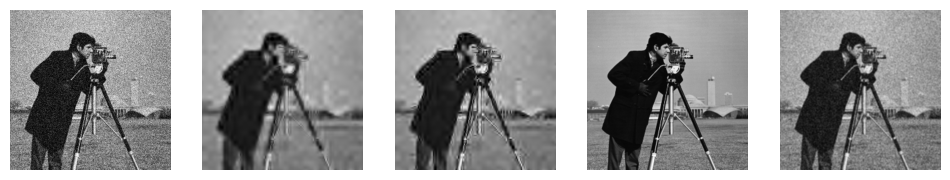

In [169]:
fig,axes = plt.subplots(nrows=1, ncols=5, figsize=(12,10))


axes[0].imshow(noisy_img, cmap='gray',vmin= 0, vmax = 1)
axes[0].axis('off')
# axes[0].set_title("DFT of H_cont (1036x1036)")

axes[1].imshow(denoised_img_soft, cmap='gray',vmin= 0, vmax = 1)
axes[1].axis('off')
# axes[1].set_title("DFT of Gaussian (1036x1036)")

axes[2].imshow(denoised_img_hard, cmap='gray',vmin= 0, vmax = 1)
axes[2].axis('off')
# axes[1].set_title("DFT of Gaussian (1036x1036)")

axes[3].imshow(img_float, cmap='gray',vmin= 0, vmax = 1)
axes[3].axis('off')
# axes[0].set_title("DFT of H_cont (1036x1036)")

axes[4].imshow(baselin_denoised_img, cmap='gray',vmin= 0, vmax = 1)
axes[4].axis('off')
# axes[0].set_title("DFT of H_cont (1036x1036)")

In [86]:
def mse(img1, img2):
  return np.mean((img1 - img2) ** 2)

In [171]:
mse(img_float, noisy_img) # np.float64(0.013002236995562282)

np.float64(0.03386431586541414)

In [173]:
mse(img_float, denoised_img_hard) # np.float64(0.00414028430669645)


np.float64(0.004555159380966705)

In [174]:
mse(img_float, denoised_img_soft)


np.float64(0.006203568979836932)

In [127]:
mse(noisy_img, denoised_img_soft) #np.float64(0.010363764662383963)


np.float64(0.013299923758617818)

In [172]:
mse(img_float, baselin_denoised_img) #np.float64(0.010363764662383963)


np.float64(0.003563249239102092)